In [1]:
#Classification of MNIST dataset 
push!(LOAD_PATH, "/home/jberez/Projects/MNIST/dockerfixed")

using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Random
using Distances
using Flux
using StatsBase
using MultivariateStats
using MLDatasets
using IterTools #Only for plots, not for program

#include("hmc_mod.jl")
#include("helper_functions.jl")
include("dockerfixed/proposals.jl")
include("dockerfixed/mnist.jl")
include("dockerfixed/utils.jl")
include("dockerfixed/NUTS.jl");

In [2]:
#Load the MNIST Data
num_samples = 10
num_classes = 10
x_train, y_train = load_mnist_train_set()
x_test, y_test = load_mnist_test_set()

x, y = balanced_set(x_train,y_train,num_samples,num_classes,2);

#Test Set
x_test, y_test = balanced_set(x_test,y_test,num_samples,num_classes);

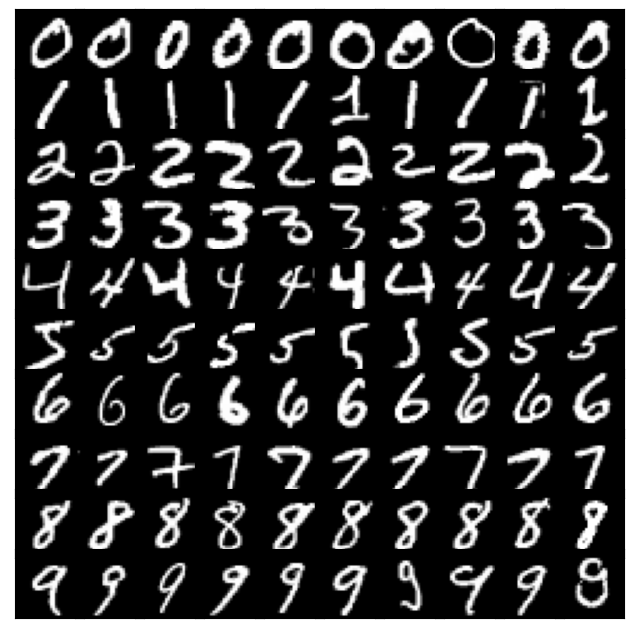

In [10]:
#Visualize Samples
x_reshaped = reshape_x(x)

nrow, ncol = num_classes,num_samples 
fig = figure("plot_mnist",figsize=(6,6))
for (i, (c, r)) in enumerate(Iterators.product(1:ncol, 1:nrow))
    subplot(nrow, ncol, i)
    imshow(x_reshaped[:,:,i]', cmap="gray")
    ax = gca()
    ax.xaxis.set_visible(false)
    ax.yaxis.set_visible(false)
end;
tight_layout(w_pad=-1, h_pad=-1, pad=-0.5);

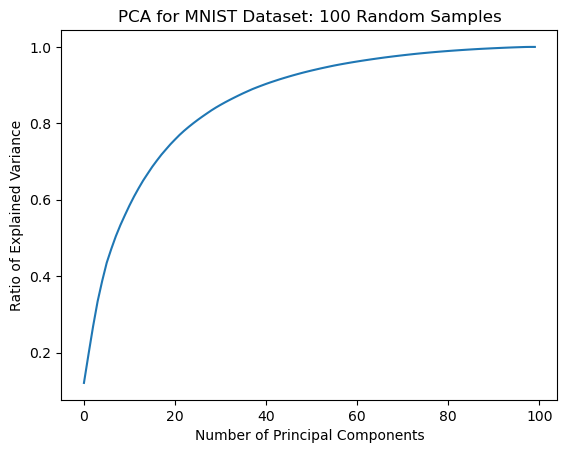

In [11]:
#Run PCA to lower dimensionality of MNIST
vars = []
x = transpose(x)
for i=1:100    
    MNIST_PCA = fit(PCA, x, maxoutdim=i, pratio=1.0)
    push!(vars,MNIST_PCA.tprinvar/MNIST_PCA.tvar)
end
plot(vars)
plt.title("PCA for MNIST Dataset: 100 Random Samples")
plt.xlabel("Number of Principal Components")
plt.ylabel("Ratio of Explained Variance");

In [12]:
#Get PCA Transform for x
dims = 20
x_pca = fit(PCA,x,maxoutdim=dims)
xt = transform(x_pca,x)

#Testing PCA Transform
xz = transform(x_pca,transpose(x_test));

In [13]:
#One-Hot Encode Y
yt = Flux.onehotbatch(y,[:1,:2,:3,:4,:5,:6,:7,:8,:9,:10]);
#yt = Flux.onehotbatch(y,[:1,:2,:3,:4,:5]);
#Test Set
yz = y_test
yzt = Flux.onehotbatch(yz,[:1,:2,:3,:4,:5,:6,:7,:8,:9,:10]);
#yzt = Flux.onehotbatch(yz,[:1,:2,:3,:4,:5]);

In [14]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
network = "classifier"

#Data hyperparameters
n = num_samples #Number of samples
c = num_classes #Number of classes
d = dims #Input dimension
N = n*c #Total samples

#Node hyperparameters
k_range = 100 #Maximum number of neurons per layer
k_list = [Int(i) for i in 1:k_range]

#NUTS
Δ_max = 1000;

In [56]:
#New Softmax
function softmax_(arr::AbstractArray)
    ex = mapslices(x -> exp.(0.5*x),arr,dims=1)
    rows, cols = size(arr)
    val = similar(ex)
    for i in 1:cols
        s = sum(ex[:,i])
        for j in 1:rows
            val[j,i] = ex[j,i]/s
        end
    end
    return val
end;

In [57]:
#Bayesian Neural Net
function G(x, trace)
    activation = tanh
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], c, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], c)
    
    nn_out = Dense(Wₒ, bₒ)
    x = nn_out(x)
    
    return softmax_(x)
end;

In [72]:
@gen function classifier(x::Array{Float64})
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers - 1 for Classifier Net
    l ~ categorical([1.0])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        obs[(:k,i)] = k[i]
    end
    output_array = zeros(Float64, c)
    output_array[c] = 1.0

    k[l+1] = @trace(categorical(output_array), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    ########################################
    #Fixed Hyperparameter schedule - Apr 26#
    ########################################
    
    σ = 1.0
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h)
            S = Diagonal([σ for j=1:length(u)])
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i])
            Sb = Diagonal([σ for j=1:length(ub)])   
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(h)
            S = Diagonal([σ for j=1:length(u)])
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(c)
            Sb = Diagonal([σ for j=1:length(ub)]) 
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    
    #Logistic Classification Likelihood
    y = zeros(length(scores))
    for j=1:length(x[1,:])
        score_vec = scores[:,j]
        #println(score_vec)
        y[j] = @trace(categorical(score_vec), (:y,j))
    end
    
    return scores
    
end;

obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

(best_trace,) = generate(classifier, (xt,), obs)
println(get_score(best_trace))
println(best_trace[(:k,1)])
test_labels = G(xt,best_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])

-2956.79743252461
53


6

In [35]:
test_labels[:,1]

10-element Array{Float64,1}:
 0.0036268412151841643
 0.0003421366749713407
 0.04544639856178072
 0.005547266097069592
 0.005066086694934669
 0.016624443161985414
 0.4815706291447712
 0.007489675244822944
 0.10388024418757283
 0.330406279016907

In [36]:
y[1]

1

In [37]:
include("dockerfixed/proposals.jl")
obs[(:k,1)] = 2
(best_trace,) = generate(classifier, (xt,), obs)
new_trace,q = node_birth(best_trace)
display(reshape(best_trace[(:W,1)], best_trace[(:k,1)], d))
display(reshape(new_trace[(:W,1)], new_trace[(:k,1)], d))
println(get_score(best_trace))
println(get_score(new_trace))

test_labels = G(xt,best_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("Old trace Accuracy: $test_acc")

test_labels = G(xt,new_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("New trace Accuracy: $test_acc")

2×20 Array{Float64,2}:
 0.693636  -0.550691   1.01168   0.250216  …  0.228539   0.213549  -0.24157
 0.161479   0.960726  -0.125286  0.645244     0.447036  -0.893079   1.4535

3×20 Array{Float64,2}:
  0.693636  -0.550691   1.01168   0.250216  …   0.228539   0.213549  -0.24157
  0.161479   0.960726  -0.125286  0.645244      0.447036  -0.893079   1.4535
 -0.213936  -1.85287    0.833187  1.04225      -0.487563  -0.745178  -1.34494

-365.22958899226813
-407.09078085276656
Old trace Accuracy: 8
New trace Accuracy: 7


In [38]:
include("dockerfixed/proposals.jl")

println("Current k: $(best_trace[(:k,1)])")
new_trace2,q = node_death(new_trace)
display(reshape(new_trace[(:W,1)], new_trace[(:k,1)], d))
display(reshape(new_trace2[(:W,1)], new_trace2[(:k,1)], d))
println(get_score(new_trace))
println(get_score(new_trace2))

test_labels = G(xt,new_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("Old trace Accuracy: $test_acc")

test_labels = G(xt,new_trace2)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("New trace Accuracy: $test_acc")

3×20 Array{Float64,2}:
  0.693636  -0.550691   1.01168   0.250216  …   0.228539   0.213549  -0.24157
  0.161479   0.960726  -0.125286  0.645244      0.447036  -0.893079   1.4535
 -0.213936  -1.85287    0.833187  1.04225      -0.487563  -0.745178  -1.34494

2×20 Array{Float64,2}:
  0.693636  -0.550691  1.01168   0.250216  …   0.228539   0.213549  -0.24157
 -0.213936  -1.85287   0.833187  1.04225      -0.487563  -0.745178  -1.34494

Current k: 2
-407.09078085276656
-357.2058246157061
Old trace Accuracy: 7
New trace Accuracy: 6


In [39]:
display(reshape(new_trace[(:W,2)],new_trace[(:k,2)],new_trace[(:k,1)]))
display(reshape(new_trace2[(:W,2)],new_trace2[(:k,2)],new_trace2[(:k,1)]))

10×3 Array{Float64,2}:
  0.0948519   0.829452   -0.10782
 -1.04305    -0.0584723  -1.22464
  1.30026     0.970134    0.462612
  0.0401744  -1.25563     0.404889
  0.241258   -0.514519    0.366021
  0.341626    1.29781     0.3528
 -0.377482    0.442706    0.0384678
  0.612113    0.258963   -1.62873
 -1.14218     0.539689    0.387508
  1.32457     0.118377   -0.0524934

10×2 Array{Float64,2}:
  0.0948519  -0.10782
 -1.04305    -1.22464
  1.30026     0.462612
  0.0401744   0.404889
  0.241258    0.366021
  0.341626    0.3528
 -0.377482    0.0384678
  0.612113   -1.62873
 -1.14218     0.387508
  1.32457    -0.0524934

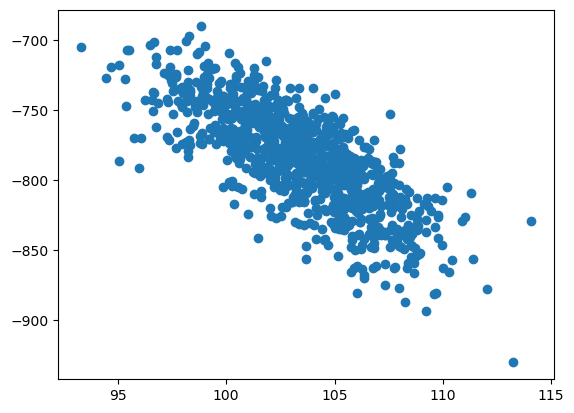

PyObject <matplotlib.collections.PathCollection object at 0x7f729980c590>

In [73]:
#Test Likelihood
obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;
obs[(:k,1)] = 10

scores = []
accs = []
traces = []
ks = []
for i = 1:1000
    (trace,) = generate(classifier, (xt,), obs)
    push!(ks,trace[(:k,1)])
    push!(scores,get_score(trace))
    push!(traces,trace)
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    test_acc = sum([y[i] == results[i] for i=1:length(y)])/length(y)
    test_acc = sum([euclidean(yt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
end

scatter(accs,scores)
#plt.xlim(50,300)
#plt.ylim(-2000,0)
#println(ks)

In [74]:
best_trace = traces[findmax(scores)[2]];

In [75]:
include("NUTS.jl")
#(best_trace,) = generate(classifier, (xt,), obs)
l = best_trace[:l]
println(best_trace[(:k,1)])
param_selection = select()
for i=1:l+1 #Number of Layers
    push!(param_selection, (:W,i))
    push!(param_selection, (:b,i))
end
traces = NUTS(best_trace, param_selection, 0.65, 100, 10, true);

10
[NUTS] start sampling for 100 samples with inital ϵ=1
..................................................................................

InterruptException: SYSTEM: show(lasterr) caused an error

In [77]:
#-------------
#Run Inference
#-------------

include("NUTS.jl")
Δ_max = 1000
acc_prob = 0.65
#Random.seed!(1)

scores = []
traces = []
ks = []
across_acceptance = []
within_acceptance = []

#Inference Hyperparameters
across_iters = 1
m = 3

@gen function gibbs_hyperparameters(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    for i=1:trace[:l] + 1
        #Biases
        bias = trace[(:b,i)]
        
        n = length(bias)
        α = α₁ + (n/2)
        
        Σ = sum(bias.^2)/2 
        β = 1/(1/β₁ + Σ)
        
        τᵦ ~ gamma(α,β)
        
        #Weights
        β₂ = trace[(:k,1)]
        
        i == 1 ? α₀ = α₁ : α₀ = α₂
        i == 1 ? β₀ = β₁ : β₀ = β₂
        
        weight = trace[(:W,i)]
        
        n = length(weight)
        α = α₀ + (n/2)
        
        Σ = sum(weight.^2)/2
        β = 1/(1/β₀ + Σ)
        
        τ ~ gamma(α,β)
        
        obs_new[(:τ,i)] = τ
        obs_new[(:τᵦ,i)] = τᵦ
    end
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

function nuts_parameters(trace)
    
    l = trace[:l]
    param_selection = select()
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:1
        new_trace = NUTS(trace, param_selection, 0.65, m, m, false)[m+1]
        new_score = get_score(new_trace)
        if prev_score != new_score
            #println("Accepted")
            return (new_trace, 1)
        else
            return (trace, 0)
        end
    end
    
    return (trace, acc)
end

function node_parameter(trace)
    obs = obs_master
    for i=1:trace[:l]+1
        obs[(:τ,i)] = trace[(:τ,i)]
        obs[(:τᵦ,i)] = trace[(:τᵦ,i)]
    end
    
    init_trace = trace
    
    #################################################RJNUTS#################################################
    #NUTS Step 1
    trace_tilde = trace
    for i=1:across_iters
        trace_tilde = gibbs_hyperparameters(trace_tilde)
        (trace_tilde,) = nuts_parameters(trace_tilde)
    end
    
    #Reversible Jump Step
    (trace_prime, q_weight) = node_change(trace_tilde)
    
    #NUTS Step 2
    trace_star = trace_prime
    for i=1:across_iters
        (trace_star,) = nuts_parameters(trace_star)
        trace_star = gibbs_hyperparameters(trace_star)
    end
    #################################################RJNUTS#################################################
        
    model_score = -get_score(init_trace) + get_score(trace_star)
    across_score = model_score + q_weight

    if rand() < exp(across_score)
        println("********** Accepted: $(trace_star[(:k,1)]) **********")
        return (trace_star, 1)
    else
        return (init_trace, 0)
    end
end

obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

#(trace,) = generate(classifier, (xt,), obs)
trace = best_trace
starting_k = trace[(:k,1)]
println("Starting k: $starting_k")
traces = []

for i=1:300
    (trace, accepted) = node_parameter(trace)
    push!(across_acceptance, accepted)
    trace  = gibbs_hyperparameters(trace)
    (trace, accepted) = nuts_parameters(trace)
    push!(within_acceptance, accepted)
    push!(scores,get_score(trace))
    push!(traces, trace)
    println("$i : $(get_score(trace))")
    flush(stdout)
    if i%10 == 0
        a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        println("Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
end

Starting k: 23
1 : -727.6503977683183
Inf warning
Inf warning
Inf warning
2 : -798.9404595060238
Inf warning
3 : -783.0536355182696
Inf warning
Inf warning
4 : -818.714325112214
Inf warning
5 : -873.438714344423
Inf warning
Inf warning
6 : -930.2267868823814
Inf warning
7 : -969.6126622136093
8 : -994.9921384785908
9 : -1108.032711799645
********** Accepted: 24 **********
10 : -1095.138625757193
Epoch 10 A Acceptance Probability: 10.0 %
Epoch 10 W Acceptance Probability: 80.0 %
Inf warning
Inf warning
11 : -1534.5667867844686
********** Accepted: 25 **********
12 : -1481.9531034212343
13 : -1481.3363344202787
14 : -1481.0637195541644
********** Accepted: 24 **********
15 : -1426.4421725799903
********** Accepted: 25 **********
16 : -1463.9527442368785
********** Accepted: 24 **********
17 : -1407.840111094337
18 : -1408.9674903703226
********** Accepted: 23 **********
19 : -1305.7409293554756
20 : -1337.0176070926589
Epoch 20 A Acceptance Probability: 30.0 %
Epoch 20 W Acceptance Proba

InterruptException: InterruptException:

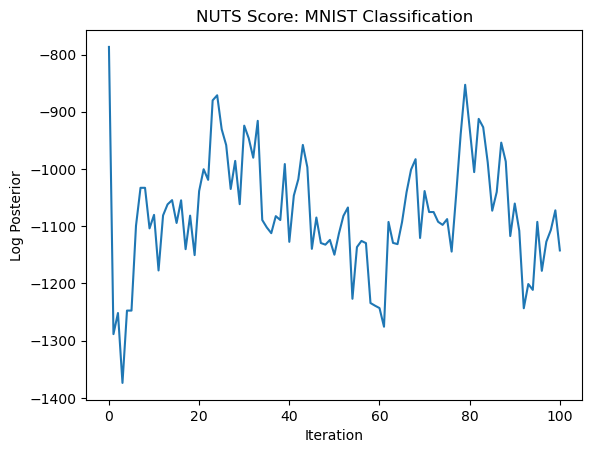

In [68]:
#Log Posterior Score Chart
obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: MNIST Classification")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

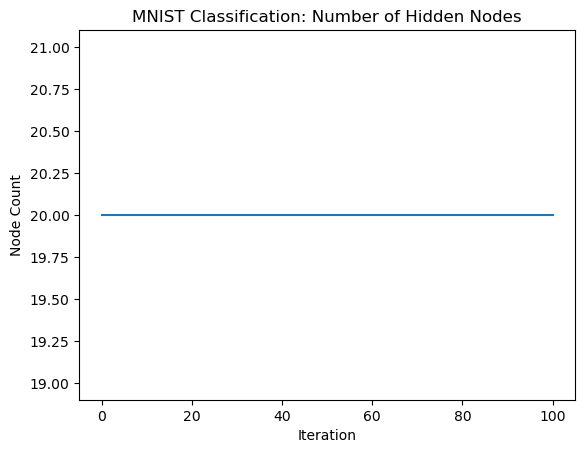

In [122]:
#Node Count Chart

plot([trace[(:k,1)] for trace in traces])
plt.title("MNIST Classification: Number of Hidden Nodes")
plt.xlabel("Iteration")
plt.ylabel("Node Count");

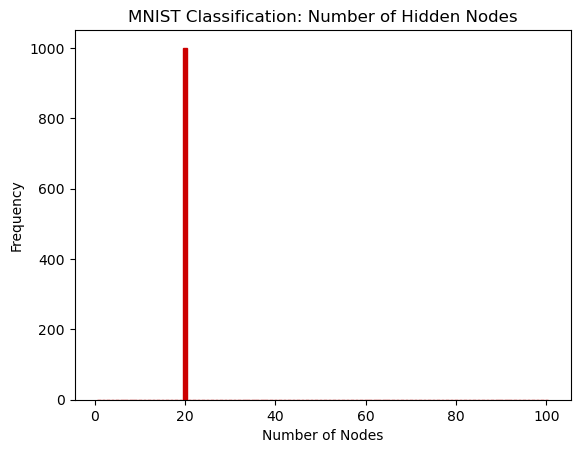

In [102]:
#Node Count Histogram

########################
#Bar Plot of l estimates
########################

ks = [traces[i][(:k,1)] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]

barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
#barlist[2].set_color([0.0,0.8,0.1])

plt.title("MNIST Classification: Number of Hidden Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Frequency");

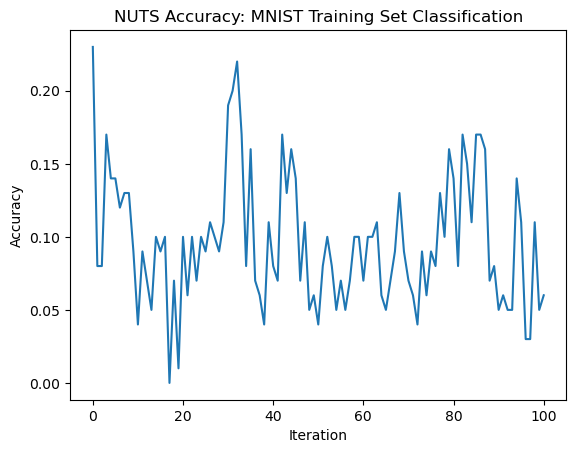

In [69]:
#Plot Training Accuracy
accs = []
dists = []
for i = 1:length(traces)
    trace = traces[i]
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    test_acc = sum([y[i] == results[i] for i=1:length(y)])/length(y)
    test_dist = sum([euclidean(yt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
    push!(dists,test_dist)
end

plot(accs)
plt.title("NUTS Accuracy: MNIST Training Set Classification")
plt.xlabel("Iteration")
plt.ylabel("Accuracy");

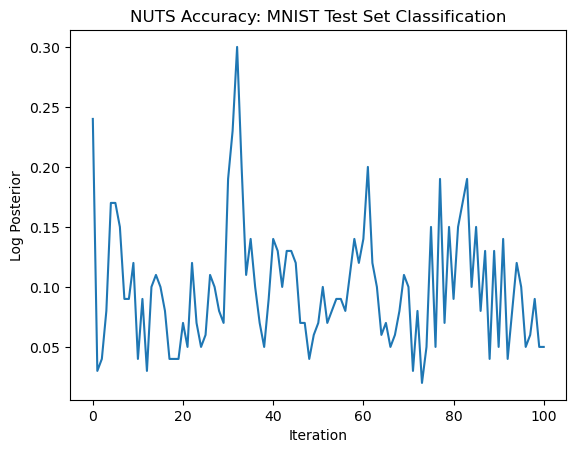

In [70]:
#Plot Testing Accuracy
accs = []
#dists = []
for i = 1:length(traces)
    trace = traces[i]
    test_labels = G(xz,trace)
    results = label_output(test_labels)
    test_acc = sum([y_test[i] == results[i] for i=1:length(y_test)])/length(y_test)
    test_dist = sum([euclidean(yzt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
    #push!(dists,test_dist)
end

plot(accs)
plt.title("NUTS Accuracy: MNIST Test Set Classification")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

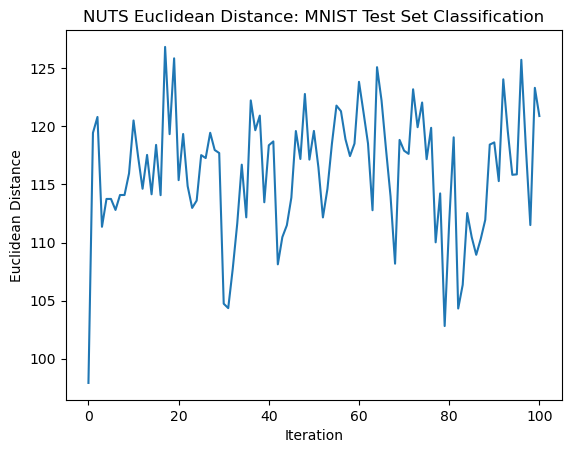

In [71]:
plot(dists)
plt.title("NUTS Euclidean Distance: MNIST Test Set Classification")
plt.xlabel("Iteration")
plt.ylabel("Euclidean Distance");

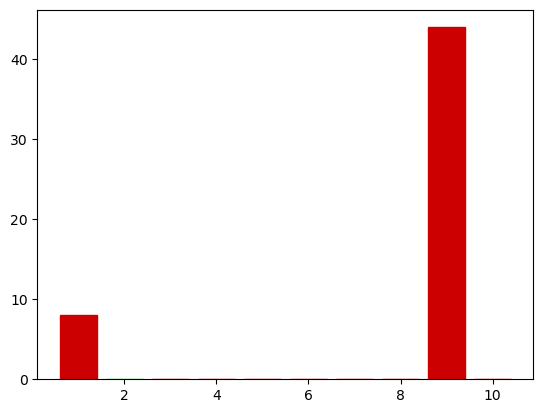

Any[1, 1, 1, 1, 1, 1, 1, 1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
2


In [69]:
#Bar Chart of Guesses For Given Target
targets = []
target = 14
for i=50:length(traces)
    trace = traces[i]
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    push!(targets,results[target])
end
#counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
counts = [sum([targets[i] == j for i in 1:length(targets)]) for j in 1:10]

barlist=bar(1:10,counts)
for i in 1:10
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[y[target]].set_color([0.0,0.8,0.1])
println(targets)
println(y[target])

In [70]:
#Marginalize Probabilities - Train Set
j = 1
targets = zeros(length(traces)-j,c,N)
for i=j:length(traces)-j
    trace = traces[i]
    labels = G(xt,trace)
    targets[i-j+1,:,:] = labels
end

sums = sum(targets,dims=1)[1,:,:]./(length(traces)-j)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([y[i] == guesses[i] for i=1:length(y)])

20

In [71]:
#Marginalize Probabilities - Test Set
j = 1
targets = zeros(length(traces)-j,c,N)
for i=j:length(traces)-j
    trace = traces[i]
    labels = G(xz,trace)
    targets[i-j+1,:,:] = labels
end

sums = sum(targets,dims=1)[1,:,:]./(length(traces)-j)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([yz[i] == guesses[i] for i=1:length(yz)])

16